## Import the dependencies

In [1]:
import tensorflow as tf     # Deep Learning library
import numpy as np          # Linear algebra library
import retro                # Environment library

from skimage import transform        # Help us to preprocess the frames
from skimage.color import rgb2gray   # Help us to grayscale our frames

import matplotlib.pyplot as plt      # Display graphs
%matplotlib inline
from collections import deque        # Ordered collections with ends

import random                        # Random numbers

import warnings                      # This ignore all the warning messages that are normally printed
                                     # during the training because of skimage

warnings.filterwarnings('ignore')

C:\Users\blefo\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\blefo\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\blefo\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\blefo\AppD

## Create our environment

In [2]:
env = retro.make(game='SpaceInvaders-Atari2600')

print("The size of our frame is: ", env.observation_space)
print("The action size is : ", 3)

# Here we create an hot encoded version of our actions
possible_actions = np.array([[1, 0, 0],  # Fire
                             [0, 1, 0],  # Move left
                             [0, 0, 1]]) # Move right

print()
print(possible_actions)

The size of our frame is:  Box(210, 160, 3)
The action size is :  3

[[1 0 0]
 [0 1 0]
 [0 0 1]]


### preprocess_frame

#### Preprocessing is an important step, because we want to reduce the complexity of our states to reduce the computation time needed for training

Our steps:
   * Grayscale each of our frames (because color doesn't add important information)
   * Crop the screen (in our example, we remove the part below the player because it doesn't add any useful information)
   * We normalize pixel values
   * Finally we resize the preprocessed frame


    
 
    

In [3]:
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12, 4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, [110, 84])
    return preprocessed_frame # 110x84x1 frame

### stack_frames

Stacking frames is really important because it helps us to give have a sense of motion to our Neural Network

But we don't stack all frames, we skip 4 frames at each timestep. This means that only every fourth frame is considered. And then, we use this frame to form the stack_frame

#### The frame skipping method is already implemented in the library

* First we preprocess frame
* Then we append the frame to the deque that automatically removes the oldest frame
* Finally we build the stacked state

    

This is how work stack:
* For the first frame, we feed the same 4 frames
* At each timestep, we add the new frame to deque and then we stack them to form a new stacked frame
* And so on
* If we're done, we create a new stack with 4 new frames (because we are in a new episode)

In [4]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames = deque([np.zeros((110, 84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110, 84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        for i in range(4):
            stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Set up our hyperparameters

In [5]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 4]         # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = 3                   # 8 possible actions
learning_rate =  0.00025          # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 101              # Total episodes for training
max_steps = 50000                 # Max possible steps in an episode
batch_size = 32                   # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 0.01              # exploration probability at start
explore_stop = 0.01               # minimum exploration probability 
decay_rate = 0.00001              # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                       # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size      # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000             # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                    # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Create our Deep Q-learning Neural Network model

This is our Deep Q-learning model:
* We take a stack of 4 frames as input
* It passes through 3 convnets
* Then it is flattened
* Finally it passes through 2 FC layers
* It outputs a Q value for each action

In [6]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_,
                                         filters=32,
                                         kernel_size=[8,8],
                                         strides=[4,4],
                                         padding="VALID",
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name="conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs=self.conv1_out,
                                 filters=64,
                                 kernel_size=[4,4],
                                 strides=[2,2],
                                 padding="VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name="conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs=self.conv2_out,
                                 filters=64,
                                 kernel_size=[3,3],
                                 strides=[2,2],
                                 padding="VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name="conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            self.fc = tf.layers.dense(inputs=self.flatten,
                                  units=512,
                                  activation=tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            self.output = tf.layers.dense(inputs=self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units=self.action_size, 
                                        activation=None)
            

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [7]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DeepQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

W0828 10:15:16.579491  8564 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0828 10:15:16.580492  8564 deprecation.py:323] From <ipython-input-6-138759b4eb66>:29: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0828 10:15:16.826808  8564 deprecation.py:323] From C:\Users\blefo\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.fl

## Experience Replay

Now that we created our Neural Network, we need to implement the Experience Replay method

Here we'll create the Memory object that creates a deque. A deque (double ended queue) is a data type that removes the oldest element each time that you add a new element.

In [8]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

Here we'll deal with the empty memory problem: we pre-populate our memory by taking random actions and storing the experience(state, action, reward, next_state)

## Instantiate memory

In [9]:
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Get the next_state, the rewards, done by taking a random action
    action = random.choice(possible_actions)
    next_state, reward, done, _ = env.step(action)
    
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state

In [10]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("tensorboard --logdir=/tensorboard/dqn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Train our Agent

Our algorithm:
<br>
* Initialize the weights
* Init the environment
* Initialize the decay rate (that will use to reduce epsilon) 
<br><br>
* **For** episode to max_episode **do** 
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
    * **endfor**
    <br><br>
* **endfor**

In [11]:
"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * (decay_step * 10))
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability

In [12]:
def change_action(action):
    action = list(random.choice(possible_actions))
    index = action.index(1)
                  
                  
    if index == 0:
        command = [1, 0, 0, 0, 0, 0, 0, 0] # Fire
    elif index == 1:
        command = [0, 0, 0, 0, 0, 0, 1, 0] # Move left
    elif index == 2:
        command = [0, 0, 0, 0, 0, 0, 0, 1] # Move Right
    
    return command

In [13]:
# Saver will help us to save our model
saver = tf.train.Saver()
if training == True:
    with tf.Session() as sess:
        

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 71
        
        rewards_list = []
        
        save_path = saver.restore(sess, "./models/model_14/model.ckpt")
        
        for episode in range(71, total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                
                # Change from an action to command
                command = change_action(action)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(command)
                
                if episode_render:
                    env.render()
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)
                    
                    print('Episode: {}'.format(episode),
                          'Total reward: {}'.format(total_reward),
                          'Explore P: {:.4f}'.format(explore_probability),
                          'Training Loss {:.4f}'.format(loss))

                    rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    
                    
                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])
                

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})
                
                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()
            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model_" + str(episode // 5) + "/model.ckpt")
                print("Model Saved")

In [14]:
import datetime
print(datetime.datetime.now())

2019-08-28 10:12:58.798405


## Visualization of model training process

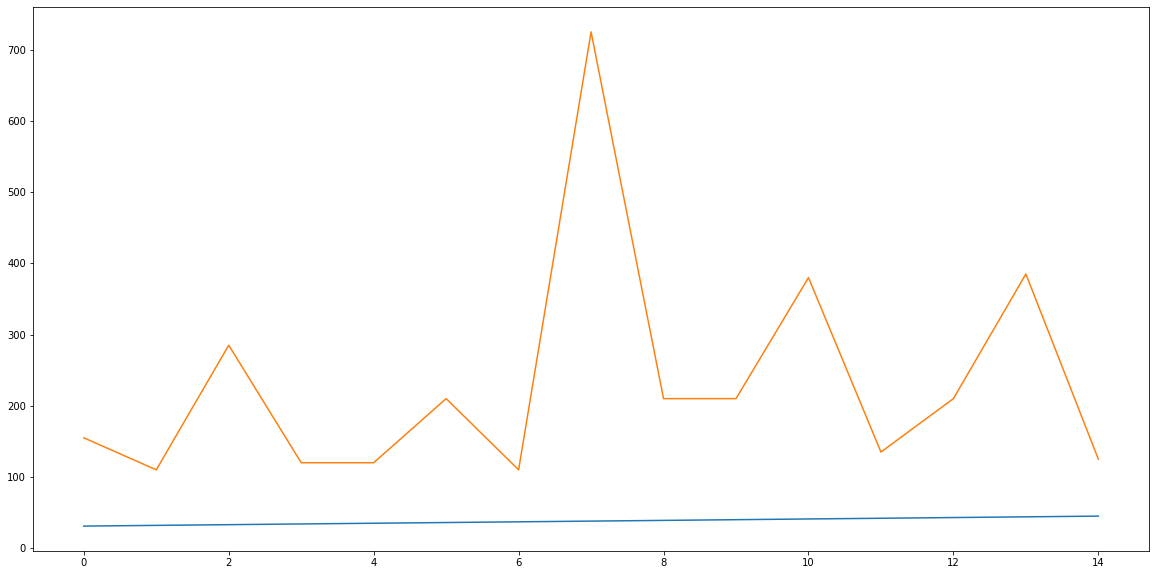

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(rewards_list)
plt.show()

## Test and Watch our Agent play
Now that we trained our agent, we can test it

In [14]:
saver = tf.train.Saver()
with tf.Session() as sess:
    total_test_rewards = []
 
    # Load the model
    save_path = saver.restore(sess, "./models/model_13/model.ckpt")
    
    for episode in range(5):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            
            # Change from an action to command
            command = change_action(action)
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(command)
            env.render()
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
            
    env.close()

W0828 10:15:26.196456  8564 deprecation.py:323] From C:\Users\blefo\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


****************************************************
EPISODE  0
Score 155.0
****************************************************
EPISODE  1
Score 450.0
****************************************************
EPISODE  2
Score 105.0
****************************************************
EPISODE  3
Score 240.0
****************************************************
EPISODE  4
Score 415.0


# 3
****************************************************
EPISODE  0
Score 155.0
****************************************************
EPISODE  1
Score 155.0
****************************************************
EPISODE  2
Score 110.0
****************************************************
EPISODE  3
Score 210.0
****************************************************
EPISODE  4
Score 410.0

# 5
****************************************************
EPISODE  0
Score 390.0
****************************************************
EPISODE  1
Score 180.0
****************************************************
EPISODE  2
Score 315.0
****************************************************
EPISODE  3
Score 310.0
****************************************************
EPISODE  4
Score 195.0